# 01 — Data Exploration & Ingestion

**Objectives**
- Load raw Superstore CSV and cleaned snapshot
- Inspect schema, dtypes, missing values
- Basic summary statistics and visualizations
- Save a cleaned snapshot (demonstration)


In [ ]:
# Environment check & imports
import sys, platform
print("Python", sys.version)
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pathlib import Path

sys.path.append('../')
from agents.data_ingestor import load_table, validate_schema, ensure_datetime, basic_preview, save_snapshot

DATA_RAW = Path("../data/raw/superstore.csv")
DATA_SNAPSHOT = Path("../data/processed/superstore_clean.parquet")


print("DATA_RAW exists:", DATA_RAW.exists())
print("DATA_SNAPSHOT exists:", DATA_SNAPSHOT.exists())


Python 3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:13:34) [MSC v.1944 64 bit (AMD64)]
DATA_RAW exists: True
DATA_SNAPSHOT exists: True


## 1) Quick peek at the raw CSV (sample)

In [2]:
# Load a small sample (keeps notebook snappy)
if DATA_RAW.exists():
    df_sample = load_table(str(DATA_RAW), sample_n=200)
    print("Sample shape:", df_sample.shape)
    display(df_sample.head())
else:
    print("No raw CSV found at", DATA_RAW)

2025-11-17 22:01:23,105 INFO salesops.data_ingestor - Reading CSV (utf-8): ..\data\raw\superstore.csv
2025-11-17 22:01:23,128 WARNING salesops.data_ingestor - utf-8 read failed for ..\data\raw\superstore.csv: 'utf-8' codec can't decode byte 0xf6 in position 9: invalid start byte. Trying latin1.
2025-11-17 22:01:23,167 INFO salesops.data_ingestor - Sampling 200 rows from 9994
2025-11-17 22:01:23,172 INFO salesops.data_ingestor - Loaded DataFrame shape=(200, 21)
Sample shape: (200, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,3126,CA-2015-121720,6/11/2015,6/12/2015,First Class,JE-15610,Jim Epp,Corporate,United States,Lakeland,...,33801,South,OFF-ST-10003816,Office Supplies,Storage,Fellowes High-Stak Drawer Files,563.808,4,0.2,21.1428
1,1442,CA-2017-128160,12/19/2017,12/24/2017,Second Class,MM-17920,Michael Moore,Consumer,United States,San Francisco,...,94110,West,OFF-BI-10001510,Office Supplies,Binders,Deluxe Heavy-Duty Vinyl Round Ring Binder,36.672,2,0.2,11.4600
2,4511,CA-2016-119935,11/10/2016,11/14/2016,Standard Class,KM-16225,Kalyca Meade,Corporate,United States,Springfield,...,65807,Central,FUR-FU-10001085,Furniture,Furnishings,3M Polarizing Light Filter Sleeves,37.300,2,0.0,17.1580
3,40,CA-2015-117415,12/27/2015,12/31/2015,Standard Class,SN-20710,Steve Nguyen,Home Office,United States,Houston,...,77041,Central,FUR-CH-10004218,Furniture,Chairs,"Global Fabric Manager's Chair, Dark Gray",212.058,3,0.3,-15.1470
4,4510,CA-2017-167003,5/23/2017,5/29/2017,Standard Class,VS-21820,Vivek Sundaresam,Consumer,United States,Los Angeles,...,90036,West,FUR-TA-10001520,Furniture,Tables,"Lesro Sheffield Collection Coffee Table, End T...",171.288,3,0.2,-6.4233


## 2) Load the cleaned snapshot (preferred for downstream work)


In [3]:
if DATA_SNAPSHOT.exists():
    df = pd.read_parquet(DATA_SNAPSHOT)
    print("Loaded snapshot shape:", df.shape)
else:
    print("Snapshot not found; loading full CSV (may be slower)")
    df = load_table(str(DATA_RAW))
    print("Loaded df shape:", df.shape)

# show head
display(df.head())

Loaded snapshot shape: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## 3) Schema, dtypes, and missing values


In [4]:
# dtypes
print("Dtypes:")
display(df.dtypes.to_frame("dtype"))

# missing values
print("\nMissing values (count):")
display(df.isna().sum().sort_values(ascending=False).head(20))

# quick basic preview helper
p = basic_preview(df, n_head=5)
print("Preview shape:", p["shape"])

Dtypes:


,dtype
Row ID,int64
Order ID,object
Order Date,datetime64[ns]
Ship Date,datetime64[ns]
Ship Mode,object
Customer ID,object
Customer Name,object
Segment,object
Country,object
City,object



Missing values (count):


Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
dtype: int64

2025-11-17 22:01:23,362 INFO salesops.data_ingestor - Generated preview for shape=(9994, 21)
Preview shape: (9994, 21)


## 4) Basic numeric summaries & distributions


,count,mean,std,min,25%,50%,75%,max
Row ID,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.750,9994.000
Postal Code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
Sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
Quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
Discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
Profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


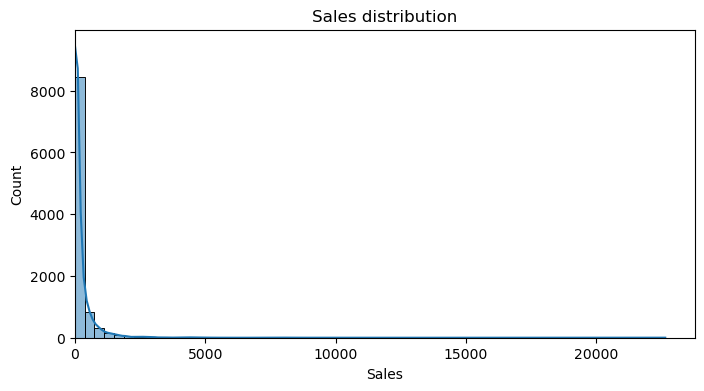

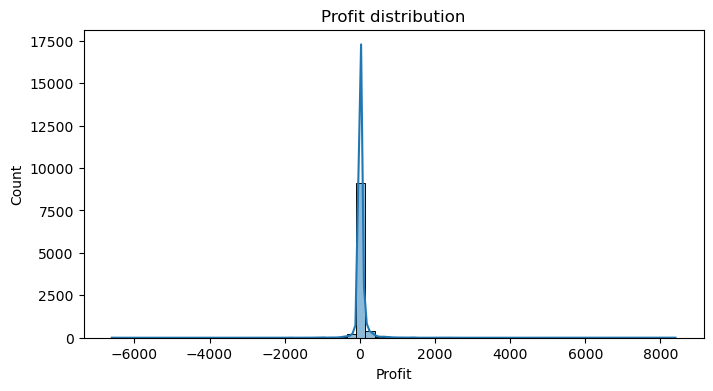

In [5]:
# numeric summary
display(df.select_dtypes(include=["number"]).describe().T)

# sales distribution
if "Sales" in df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df["Sales"].dropna(), bins=60, kde=True)
    plt.title("Sales distribution")
    plt.xlim(left=0)
    plt.show()

# profit distribution
if "Profit" in df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df["Profit"].dropna(), bins=60, kde=True)
    plt.title("Profit distribution")
    plt.show()

## 5) Time series checks (Order Date)


Time series length: 1458


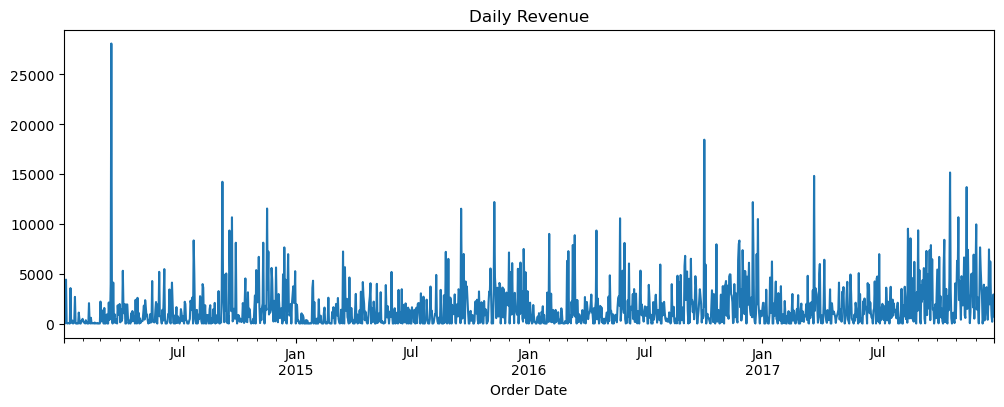

In [6]:
# Ensure Order Date is datetime
if "Order Date" in df.columns:
    df = ensure_datetime(df, "Order Date")

# basic time series: daily revenue
if "Order Date" in df.columns and "Sales" in df.columns:
    ts = df.set_index("Order Date").resample("D")["Sales"].sum().fillna(0)
    print("Time series length:", len(ts))
    plt.figure(figsize=(12, 4))
    ts.plot(title="Daily Revenue")
    plt.show()
else:
    print("Order Date or Sales missing.")

## 6) Category & Region breakdowns


In [7]:
if "Category" in df.columns and "Sales" in df.columns:
    cat = df.groupby("Category")["Sales"].sum().sort_values(ascending=False)
    print("Revenue by Category:")
    display(cat.to_frame("Revenue"))

if "Region" in df.columns and "Sales" in df.columns:
    reg = df.groupby("Region")["Sales"].sum().sort_values(ascending=False)
    print("Revenue by Region:")
    display(reg.to_frame("Revenue"))

Revenue by Category:


,Revenue
Category,
Technology,836154.0330
Furniture,741999.7953
Office Supplies,719047.0320


Revenue by Region:


,Revenue
Region,
West,725457.8245
East,678781.2400
Central,501239.8908
South,391721.9050


## 7) Quick anomaly probe (z-score on daily revenue)


In [8]:
from scipy import stats

if "Order Date" in df.columns and "Sales" in df.columns:
    daily = df.set_index("Order Date").resample("D")["Sales"].sum().fillna(0)
    z = stats.zscore(daily.values, nan_policy="omit")
    zdf = pd.DataFrame({"date": daily.index, "revenue": daily.values, "zscore": z})
    # show top absolute zscore days
    display(zdf.sort_values("zscore", key=abs, ascending=False).head(10))
else:
    print("Skipping anomaly probe (missing columns).")

,date,revenue,zscore
74,2014-03-18,28106.7160,11.925262
1003,2016-10-02,18452.9720,7.586080
1388,2017-10-22,15158.8770,6.105444
1175,2017-03-23,14816.0680,5.951357
248,2014-09-08,14228.4280,5.687224
1414,2017-11-17,13694.8828,5.447405
674,2015-11-08,12196.9970,4.774132
1079,2016-12-17,12185.1340,4.768800
318,2014-11-17,11544.2740,4.480745
622,2015-09-17,11525.0060,4.472085


## 8) Save a cleaned snapshot (demo)


In [9]:
# Save cleaned snapshot as parquet (or CSV with to_parquet=False)
out_path = save_snapshot(
    df,
    out_dir="../data/processed",
    filename="superstore_from_notebook",
    to_parquet=True,
)
print("Saved snapshot to:", out_path)

2025-11-17 22:01:24,040 INFO salesops.data_ingestor - Saved snapshot to ..\data\processed\superstore_from_notebook.parquet
Saved snapshot to: ..\data\processed\superstore_from_notebook.parquet


## 9) Next steps (Day 1)
- Build KPI agent (compute KPIs, rolling metrics)
- Build anomaly detection agent (statistical + LLM explainers)
- Wire a simple pipeline notebook to run ingestion -> KPI -> anomaly -> insights
